In [38]:
# 导入所需库
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from matplotlib.colors import LinearSegmentedColormap
import warnings
import xarray as xr
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
from datetime import datetime

warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False


output_dir = 'ndvi_output'




In [39]:

def create_multiband_dataset(date, hls_folder, bands=['B04','B05']):
    '''
    為您的 HLS 檔案結構創建多波段 xarray dataset
    
    參數:
    - date: 日期字串 (例如: '2024169')
    - hls_folder: HLS 資料夾路徑
    - bands: 要載入的波段列表 (例如: ['B04', 'B05'])
    - chunks: xarray 分塊設定
    '''
    
    # 找到指定日期的所有檔案
    pattern = f"*{date}*"
    files = glob(os.path.join(hls_folder, pattern))
    
    # 創建波段檔案對應字典
    band_files = {}
    for file in files:
        for band in bands:
            if f".{band}.tif" in file:
                band_files[band] = file
                break
    
    print(f"找到的波段檔案:")
    for band, file_path in band_files.items():
        print(f"  {band}: {os.path.basename(file_path)}")
    
    # 載入每個波段
    datasets = []
    for band in bands:
        if band in band_files:
            file_path = band_files[band]
            print(f"載入 {band} 波段: {os.path.basename(file_path)}")
            
            # 使用 rasterio 讀取資料並轉換為 xarray
            with rasterio.open(file_path) as src:
                data = src.read(1)  # 讀取第一個波段
                transform = src.transform
                crs = src.crs
                
                # 創建座標
                height, width = data.shape
                x_coords = np.arange(width) * transform[0] + transform[2]
                y_coords = np.arange(height) * transform[4] + transform[5]
                
                # 創建 xarray DataArray
                da = xr.DataArray(
                    data, 
                    coords={
                        'y': y_coords,
                        'x': x_coords
                    },
                    dims=['y', 'x'],
                    name=band,
                    attrs={
                        'crs': crs,
                        'transform': transform
                    }
                )
                ds = da.to_dataset(name=band)
            datasets.append(ds)
        else:
            print(f"⚠️  找不到 {band} 波段的檔案")
    
    if datasets:
        DS = xr.merge(datasets)
        print(f"成功創建包含 {list(DS.data_vars.keys())} 的 dataset")
        return DS
    else:
        print("❌ 沒有成功載入任何波段")
        return None

# 保存 NDVI 到 TIFF 的函數
def save_ndvi_to_tiff(ndvi_data, output_path, transform=None, crs=None, nodata_value=-9999):

    """
    保存 NDVI 數據到 GeoTIFF 文件
    
    參數:
    - ndvi_data: NDVI 數據 (numpy array 或 xarray DataArray)
    - output_path: 輸出文件路徑
    - transform: 地理變換參數
    - crs: 座標參考系統
    - nodata_value: NoData 值
    """
    import rasterio
    from rasterio.crs import CRS
    from rasterio.transform import from_bounds
    
    try:
        # 如果是 xarray DataArray，提取數據和屬性
        if hasattr(ndvi_data, 'values'):
            data = ndvi_data.values
            if transform is None and hasattr(ndvi_data, 'attrs') and 'transform' in ndvi_data.attrs:
                transform = ndvi_data.attrs['transform']
            if crs is None and hasattr(ndvi_data, 'attrs') and 'crs' in ndvi_data.attrs:
                crs = ndvi_data.attrs['crs']
        else:
            data = ndvi_data
        
        # 處理 NaN 值
        data = np.where(np.isnan(data), nodata_value, data)
        
        # 如果沒有提供 transform，嘗試從 xarray 座標計算
        if transform is None and hasattr(ndvi_data, 'coords'):
            try:
                x_coords = ndvi_data.coords['x'].values
                y_coords = ndvi_data.coords['y'].values
                if len(x_coords) > 1 and len(y_coords) > 1:
                    x_res = x_coords[1] - x_coords[0]
                    y_res = y_coords[1] - y_coords[0]
                    transform = from_bounds(
                        x_coords[0] - x_res/2, 
                        y_coords[-1] - y_res/2,
                        x_coords[-1] + x_res/2, 
                        y_coords[0] + y_res/2,
                        data.shape[1], 
                        data.shape[0]
                    )
            except:
                pass
        
        # 如果仍然沒有 transform，使用默認值
        if transform is None:
            transform = from_bounds(0, 0, data.shape[1], data.shape[0], data.shape[1], data.shape[0])
        
        # 如果沒有提供 CRS，使用默認值
        if crs is None:
            crs = CRS.from_epsg(4326)
        
        # 確保數據類型正確
        if data.dtype != np.float32:
            data = data.astype(np.float32)
        
        # 寫入 GeoTIFF
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=data.shape[0],
            width=data.shape[1],
            count=1,
            dtype=data.dtype,
            crs=crs,
            transform=transform,
            nodata=nodata_value,
            compress='lzw'
        ) as dst:
            dst.write(data, 1)
        
        print(f"✅ NDVI 已保存到: {output_path}")
        return True
        
    except Exception as e:
        print(f"❌ 保存 NDVI 時發生錯誤: {e}")
        return False



# # 創建修正版本的保存函數
def save_ndvi_with_correct_georeference(ndvi_data, output_path, original_transform=None, original_crs=None):
    """
    使用正確的地理參考保存 NDVI
    """
    import rasterio
    
    # 如果是 xarray DataArray，提取資料
    if hasattr(ndvi_data, 'values'):
        data = ndvi_data.values
    else:
        data = ndvi_data
    
    # 處理 NaN 值
    data_clean = np.where(np.isnan(data), -9999, data)
    
    # 使用原始的地理資訊
    if original_transform is None and 'original_transform' in locals():
        original_transform = globals()['original_transform']
    if original_crs is None and 'original_crs' in locals():
        original_crs = globals()['original_crs']
    
    if original_transform is None:
        print("❌ 沒有原始地理資訊，無法正確保存")
        return False
    
    # 保存為 GeoTIFF
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=data_clean.shape[0],
        width=data_clean.shape[1],
        count=1,
        dtype=data_clean.dtype,
        crs=original_crs,
        transform=original_transform,
        nodata=-9999,
        compress='lzw'
    ) as dst:
        dst.write(data_clean, 1)
    
    print(f"✅ 修正版 NDVI 已保存到: {output_path}")
    print(f"   使用原始 transform: {original_transform}")
    print(f"   使用原始 CRS: {original_crs}")
    
    return True

# 完全修正版 LST 處理器（正確的公式和索引）
class LSTProcessorFixed:
    def __init__(self):
        # 波段對應關係
        self.band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07']
        self.band_descriptions = ['Coastal', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']
    
    def calculate_NDVI(self, reflectance):
        """計算 NDVI - (NIR - Red) / (NIR + Red)"""
        # 索引 4=NIR, 3=Red
        check = np.logical_and(reflectance[4] > 0, reflectance[3] > 0)
        NDVI = np.where(check, ((reflectance[4] - reflectance[3]) / (reflectance[4] + reflectance[3])), -1)
        print(f'NDVI = ({self.band_names[4]}-{self.band_names[3]})/({self.band_names[4]}+{self.band_names[3]}) = (NIR-Red)/(NIR+Red)')
        return NDVI
    
    def calculate_NDMI(self, reflectance):
        """計算 NDMI - (NIR - SWIR1) / (NIR + SWIR1)"""
        # 索引 4=NIR, 5=SWIR1
        check = np.logical_and(reflectance[4] > 0, reflectance[5] > 0)
        NDMI = np.where(check, ((reflectance[4] - reflectance[5]) / (reflectance[4] + reflectance[5])), -1)
        print(f'NDMI = ({self.band_names[4]}-{self.band_names[5]})/({self.band_names[4]}+{self.band_names[5]}) = (NIR-SWIR1)/(NIR+SWIR1)')
        return NDMI
    
    def calculate_NDBI(self, reflectance):
        """計算 NDBI - (SWIR1 - NIR) / (SWIR1 + NIR)"""
        # 索引 5=SWIR1, 4=NIR
        check = np.logical_and(reflectance[5] > 0, reflectance[4] > 0)
        NDBI = np.where(check, ((reflectance[5] - reflectance[4]) / (reflectance[5] + reflectance[4])), -1)
        print(f'NDBI = ({self.band_names[5]}-{self.band_names[4]})/({self.band_names[5]}+{self.band_names[4]}) = (SWIR1-NIR)/(SWIR1+NIR)')
        return NDBI
    
    def calculate_MNDWI(self, reflectance):
        """計算 MNDWI - (Green - SWIR1) / (Green + SWIR1)"""
        # 索引 2=Green, 5=SWIR1
        check = np.logical_and(reflectance[2] > 0, reflectance[5] > 0)
        MNDWI = np.where(check, ((reflectance[2] - reflectance[5]) / (reflectance[2] + reflectance[5])), -1)
        print(f'MNDWI = ({self.band_names[2]}-{self.band_names[5]})/({self.band_names[2]}+{self.band_names[5]}) = (Green-SWIR1)/(Green+SWIR1)')
        return MNDWI
    
    def calculate_ALBEDO(self, reflectance):
        """計算地表反照率 - 多波段加權平均"""
        # 檢查必要的波段
        check = np.logical_and(reflectance[1] > 0, reflectance[5] > 0)  # Blue > 0, SWIR1 > 0
        ALBEDO = np.where(check, 
                         ((0.356 * reflectance[1]) + (0.15 * reflectance[3]) + (0.373 * reflectance[4]) +
                          (0.085 * reflectance[5]) + (0.072 * reflectance[6]) - 0.0018) / 1.016, 
                         -1)
        print(f'ALBEDO = 多波段加權平均 (B02, B04, B05, B06, B07)')
        return ALBEDO
    
    def calculate_vegetation_proportion(self, reflectance):
        """計算植被比例 - 基於 NDVI"""
        ndvi_array = self.calculate_NDVI(reflectance)
        valid_ndvi = ndvi_array[ndvi_array != -1]
        if len(valid_ndvi) > 0:
            vegetation_proportion = ((ndvi_array - ndvi_array.min()) / (ndvi_array.max() - ndvi_array.min())) ** 2
            vegetation_proportion = np.where(ndvi_array == -1, -1, vegetation_proportion)
        else:
            vegetation_proportion = np.full_like(ndvi_array, -1)
        print(f'植被比例 = ((NDVI - NDVI_min) / (NDVI_max - NDVI_min))^2')
        return vegetation_proportion
    
    def calculate_emissivity(self, reflectance):
        """計算地表發射率 - 基於植被比例"""
        vegetation_proportion = self.calculate_vegetation_proportion(reflectance)
        emissivity = np.where(vegetation_proportion != -1, 0.004 * vegetation_proportion + 0.986, -1)
        print(f'地表發射率 = 0.004 × 植被比例 + 0.986')
        return emissivity
    
    def calculate_LST(self, brightness, reflectance):
        """計算地表溫度 (LST) - 使用熱紅外波段"""
        ndvi_array = self.calculate_NDVI(reflectance)
        # brightness[0] = B10, brightness[1] = B11
        check = np.logical_and(brightness[0] > 0, brightness[1] > 0)
        
        # 植被比例
        # valid_ndvi = ndvi_array[ndvi_array != -1]
        # if len(valid_ndvi) > 0:
        #     pv = ((ndvi_array - ndvi_array.min()) / (ndvi_array.max() - ndvi_array.min())) ** 2
        #     pv = np.where(ndvi_array == -1, 0, pv)
        # else:
        #     pv = np.zeros_like(ndvi_array)
        

        ndvi_min, ndvi_max = 0.2, 0.5
        pv = ((ndvi_array - ndvi_min) / (ndvi_max - ndvi_min)) ** 2
        pv[ndvi_array < ndvi_min] = 0
        pv[ndvi_array > ndvi_max] = 1

        # 地表發射率
        em = 0.004 * pv + 0.986
        
        # 計算 LST (Band 10)
        lst_10 = np.where(check, (((brightness[0]*0.01) / (1 + (0.00115 * brightness[0] / 1.4388) * np.log(em))) ), -1)
        
        # # 計算 LST (Band 11)
        # lst_11 = np.where(check, ((brightness[1] / (1 + (0.00115 * brightness[1] / 1.4388) * np.log(em))) - 273.15), -1)
        
        # 平均 LST
        # lst_avg = (np.array(lst_10) + np.array(lst_11)) / 2
        lst_avg = lst_10
        print(f'LST = 平均(B10_LST, B11_LST)')
        return lst_avg

    def calculate_LST_revised(self, brightness, reflectance):
        """
        計算地表溫度 (LST) - 使用 Landsat Band 10 的單通道演算法。
        
        Args:
            brightness (list/np.array): 包含熱紅外波段的陣列，brightness[0] 應為 B10。
            reflectance (list/np.array): 包含光學波段的陣列，用於計算 NDVI。
            
        Returns:
            np.array: 計算出的 LST 陣列 (單位：攝氏度)。
        """
        # 步驟 1: 計算 NDVI
        ndvi_array = self.calculate_NDVI(reflectance)
        
        # 步驟 2: 計算植被比例 (Pv) - 使用固定閾值法
        ndvi_min, ndvi_max = 0.2, 0.5
        pv = ((ndvi_array - ndvi_min) / (ndvi_max - ndvi_min)) ** 2
        pv[ndvi_array < ndvi_min] = 0
        pv[ndvi_array > ndvi_max] = 1
        
        # 步驟 3: 計算地表發射率 (Emissivity)
        # 假設 NDVI 的 NoData 值為 -9999
        em = 0.004 * pv + 0.986
        em = np.where(ndvi_array > -9999, em, np.nan) # 將 NoData 區域設為 nan
        
        # 步驟 4: 計算亮度溫度 (BT)
        # HLS Landsat 的 B10 已經是 scaled BT，乘以 0.01 得到絕對溫度 (Kelvin)
        bt_kelvin = brightness[0] * 0.01
        
        # 步驟 5: 計算最終 LST (只使用 Band 10)
        lambda_val = 10.9e-6  # Landsat 8/9 Band 10 的中心波長 (m)
        rho = 1.438e-2      # 物理常數 (m·K)
        
        # 進行發射率校正
        # 處理 log(0) 或 log(nan) 的情況
        with np.errstate(divide='ignore', invalid='ignore'):
            lst_kelvin = bt_kelvin / (1 + (lambda_val * bt_kelvin / rho) * np.log(em))
        
        # 轉換為攝氏度
        lst_celsius = lst_kelvin 
        
        # 將原始的 NoData 區域還原
        lst_celsius = np.where(brightness[0] > 0, lst_celsius, -9999) # 假設原始 NoData > 0
        
        print('LST (from Band 10 only) calculation complete, with max/min:', np.max(lst_celsius), np.min(lst_celsius))
        return lst_celsius
    



In [40]:
# 使用 HLSL30 Landsat 資料計算 NDVI
# NDVI = (NIR - Red) / (NIR + Red)
# 對於 Landsat 8/9: NIR = B05, Red = B04

# 讀取台北市邊界
taipei_boundary = gpd.read_file('taipei_boundary.geojson')

# 檢查座標參考系統
print("台北市邊界 CRS:", taipei_boundary.crs)

# 獲取所有日期的 Landsat 資料
hls_folder = 'HLSL30_2.0-20251002_030558'
all_files = os.listdir(hls_folder)
tif_files = [f for f in all_files if f.endswith('.tif')]

# 提取所有日期
dates = set()
for file in tif_files:
    if 'B04' in file or 'B05' in file:  # 只處理紅光和近紅外波段
        # 從檔案名稱中提取日期：HLS.L30.T51RUH.2024169T021958.v2.0.B04.tif
        # 尋找 2024xxx 格式的日期
        import re
        date_match = re.search(r'(\d{7})', file)  # 尋找7位數字
        if date_match:
            date_part = date_match.group(1)
            dates.add(date_part)

dates = sorted(list(dates))
print(f"找到 {len(dates)} 個日期的資料: {dates}")

# 顯示檔案名稱範例以便除錯
print(f"\n檔案名稱範例:")
for file in tif_files[:3]:
    print(f"  {file}")

# 選擇第一個日期進行示範
selected_date = dates[0]
print(f"\n使用日期: {selected_date}")

# 找到對應的紅光和近紅外波段檔案
red_file = None
nir_file = None

for file in tif_files:
    if selected_date in file:
        if 'B04' in file:
            red_file = os.path.join(hls_folder, file)
        elif 'B05' in file:
            nir_file = os.path.join(hls_folder, file)

print(f"紅光波段 (B04): {os.path.basename(red_file)}")
print(f"近紅外波段 (B05): {os.path.basename(nir_file)}")



台北市邊界 CRS: EPSG:4326
找到 16 個日期的資料: ['2022251', '2023190', '2024169', '2024177', '2024185', '2024193', '2024201', '2024209', '2024217', '2024225', '2024233', '2024241', '2024249', '2024257', '2024273', '2025211']

檔案名稱範例:
  HLS.L30.T51RUH.2025179T022007.v2.0.SAA.tif
  HLS.L30.T51RUH.2024225T022000.v2.0.VZA.tif
  HLS.L30.T51RUH.2024193T021948.v2.0.B09.tif

使用日期: 2022251
紅光波段 (B04): HLS.L30.T51RUH.2022251T022038.v2.0.B04.tif
近紅外波段 (B05): HLS.L30.T51RUH.2022251T022038.v2.0.B05.tif


In [46]:


TEST_DATE = '2025211'

LST_RESULT_FILE = f"lst_result_fixed_{TEST_DATE}.tif"
NDVI_RESULT_FILE = f"ndvi_result_fixed_{TEST_DATE}.tif"


# 創建單一日期 dataset
if TEST_DATE:
    ds_single = create_multiband_dataset(TEST_DATE, hls_folder, bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07','B09','B10','B11'])
else:
    print("❌ 無法測試單一日期 dataset")
    ds_single = None

if ds_single is not None:
    print(f"\n單一日期 dataset 資訊:")
    print(f"  數據變數: {list(ds_single.data_vars.keys())}")
    print(f"  座標: {list(ds_single.coords.keys())}")
    print(f"  維度: {ds_single.dims}")
    print(f"  形狀: {ds_single.B04.shape}")
    
    # 顯示基本統計
    print(f"\nB04 (紅光) 統計:")
    print(f"  範圍: {ds_single.B04.min().values:.4f} 到 {ds_single.B04.max().values:.4f}")
    print(f"  平均值: {ds_single.B04.mean().values:.4f}")
    
    print(f"\nB05 (近紅外) 統計:")
    print(f"  範圍: {ds_single.B05.min().values:.4f} 到 {ds_single.B05.max().values:.4f}")
    print(f"  平均值: {ds_single.B05.mean().values:.4f}")

print("\n" + "="*50)


# 檢查和修正地理資訊
print("=== 檢查地理資訊 ===")

# 檢查原始 Landsat 資料的地理資訊
if 'red_file' in locals() and 'nir_file' in locals():
    print("1. 檢查原始 Landsat 資料的地理資訊:")
    with rasterio.open(red_file) as src:
        print(f"   原始 transform: {src.transform}")
        print(f"   原始 CRS: {src.crs}")
        print(f"   原始 bounds: {src.bounds}")
        print(f"   原始 shape: {src.shape}")
        
        # 保存原始地理資訊供後續使用
        original_transform = src.transform
        original_crs = src.crs
        original_bounds = src.bounds


print("\n✅ 地理資訊檢查完成")




print("=== 使用修正版 LST 處理器 ===")

# 創建修正版處理器實例
lst_processor_fixed = LSTProcessorFixed()

# 檢查是否有完整的 dataset
if 'ds_single' in locals() and ds_single is not None:
    print(f"\n1. 使用修正版處理器重新計算...")
    
    # 準備反射率資料
    required_reflectance = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07']
    reflectance_data = []
    for band in required_reflectance:
        reflectance_data.append(ds_single[band].values)
    reflectance = np.array(reflectance_data)
    print(f"   反射率資料形狀: {reflectance.shape}")
    
    # 計算各種指數
    print(f"\n2. 計算遙感指數...")
    
    try:
        print("   計算 NDVI...")
        ndvi = lst_processor_fixed.calculate_NDVI(reflectance)
        
        
        print("   計算 NDBI...")
        ndbi = lst_processor_fixed.calculate_NDBI(reflectance)
        
        print("   計算 MNDWI...")
        mndwi = lst_processor_fixed.calculate_MNDWI(reflectance)
        
        print("   計算 ALBEDO...")
        albedo = lst_processor_fixed.calculate_ALBEDO(reflectance)
        
        print("   計算植被比例...")
        vegetation = lst_processor_fixed.calculate_vegetation_proportion(reflectance)
        
        print("   計算地表發射率...")
        emissivity = lst_processor_fixed.calculate_emissivity(reflectance)
        
        # 顯示統計資訊
        print(f"\n3. 指數統計資訊:")
        indices = {
            'NDVI': ndvi,
            'NDBI': ndbi,
            'MNDWI': mndwi,
            'ALBEDO': albedo,
            'Vegetation': vegetation,
            'Emissivity': emissivity
        }
        
        for name, data in indices.items():
            valid_data = data[data != -1]
            if len(valid_data) > 0:
                print(f"   {name}: {np.min(valid_data):.4f} 到 {np.max(valid_data):.4f} (平均: {np.mean(valid_data):.4f})")
            else:
                print(f"   {name}: 無有效資料")
        
    except Exception as e:
        print(f"   ❌ 計算指數時發生錯誤: {e}")
        import traceback
        traceback.print_exc()
    
    # 計算 LST
    print(f"\n4. 計算 LST...")
    
    try:
        # 準備亮度溫度資料
        required_thermal = ['B10', 'B11']
        brightness_data = []
        for band in required_thermal:
            brightness_data.append(ds_single[band].values)
        brightness = np.array(brightness_data)
        print(f"   亮度溫度資料形狀: {brightness.shape}")
        
        # 計算 LST
        lst = lst_processor_fixed.calculate_LST(brightness, reflectance)
        
        # 顯示 LST 統計
        valid_lst = lst[lst != -1]
        if len(valid_lst) > 0:
            print(f"   LST 範圍: {np.min(valid_lst):.2f}°C 到 {np.max(valid_lst):.2f}°C")
            print(f"   LST 平均: {np.mean(valid_lst):.2f}°C")
            print(f"   LST 中位數: {np.median(valid_lst):.2f}°C")
            print(f"   LST 標準差: {np.std(valid_lst):.2f}°C")
            
            # 保存 LST 結果
            lst_output_path = os.path.join(output_dir, LST_RESULT_FILE)
            if 'original_transform' in locals() and 'original_crs' in locals():
                success = save_ndvi_with_correct_georeference(
                    lst, 
                    lst_output_path, 
                    original_transform, 
                    original_crs
                )
            else:
                success = save_ndvi_to_tiff(lst, lst_output_path)
            
            if success:
                print(f"   ✅ LST 已保存到: {lst_output_path}")
        else:
            print("   ⚠️  無法計算 LST（缺少有效資料）")
            
    except Exception as e:
        print(f"   ❌ 計算 LST 時發生錯誤: {e}")
        import traceback
        traceback.print_exc()
    
    # 保存 NDVI 到 TIFF 文件
    print(f"\n5. 保存 NDVI 到 TIFF 文件...")
    
    try:
        if 'ndvi' in locals() and ndvi is not None:
            # 準備 NDVI 輸出路徑
            ndvi_output_path = os.path.join(output_dir, NDVI_RESULT_FILE)
            
            # 使用正確的地理參考保存 NDVI
            if 'original_transform' in locals() and 'original_crs' in locals():
                success = save_ndvi_with_correct_georeference(
                    ndvi, 
                    ndvi_output_path, 
                    original_transform, 
                    original_crs
                )
            else:
                success = save_ndvi_to_tiff(ndvi, ndvi_output_path)
            
            if success:
                print(f"   ✅ NDVI 已保存到: {ndvi_output_path}")
                
                # 顯示 NDVI 統計資訊
                valid_ndvi = ndvi[ndvi != -1]
                if len(valid_ndvi) > 0:
                    print(f"   NDVI 範圍: {np.min(valid_ndvi):.4f} 到 {np.max(valid_ndvi):.4f}")
                    print(f"   NDVI 平均: {np.mean(valid_ndvi):.4f}")
                    print(f"   NDVI 中位數: {np.median(valid_ndvi):.4f}")
            else:
                print("   ❌ NDVI 保存失敗")
        else:
            print("   ⚠️  沒有找到 NDVI 資料")
            
    except Exception as e:
        print(f"   ❌ 保存 NDVI 時發生錯誤: {e}")
        import traceback
        traceback.print_exc()

else:
    print("❌ 沒有找到完整的 dataset")

print(f"\n✅ 修正版 LST 和 NDVI 計算完成")



找到的波段檔案:
  B01: HLS.L30.T51RUH.2025211T022017.v2.0.B01.tif
  B02: HLS.L30.T51RUH.2025211T022017.v2.0.B02.tif
  B03: HLS.L30.T51RUH.2025211T022017.v2.0.B03.tif
  B07: HLS.L30.T51RUH.2025211T022017.v2.0.B07.tif
  B06: HLS.L30.T51RUH.2025211T022017.v2.0.B06.tif
  B04: HLS.L30.T51RUH.2025211T022017.v2.0.B04.tif
  B10: HLS.L30.T51RUH.2025211T022017.v2.0.B10.tif
  B11: HLS.L30.T51RUH.2025211T022017.v2.0.B11.tif
  B05: HLS.L30.T51RUH.2025211T022017.v2.0.B05.tif
  B09: HLS.L30.T51RUH.2025211T022017.v2.0.B09.tif
載入 B01 波段: HLS.L30.T51RUH.2025211T022017.v2.0.B01.tif
載入 B02 波段: HLS.L30.T51RUH.2025211T022017.v2.0.B02.tif
載入 B03 波段: HLS.L30.T51RUH.2025211T022017.v2.0.B03.tif
載入 B04 波段: HLS.L30.T51RUH.2025211T022017.v2.0.B04.tif
載入 B05 波段: HLS.L30.T51RUH.2025211T022017.v2.0.B05.tif
載入 B06 波段: HLS.L30.T51RUH.2025211T022017.v2.0.B06.tif
載入 B07 波段: HLS.L30.T51RUH.2025211T022017.v2.0.B07.tif
載入 B09 波段: HLS.L30.T51RUH.2025211T022017.v2.0.B09.tif
載入 B10 波段: HLS.L30.T51RUH.2025211T022017.v2.0.B10.tif
載入 B1

=== 繪製 LST 分布圖 ===


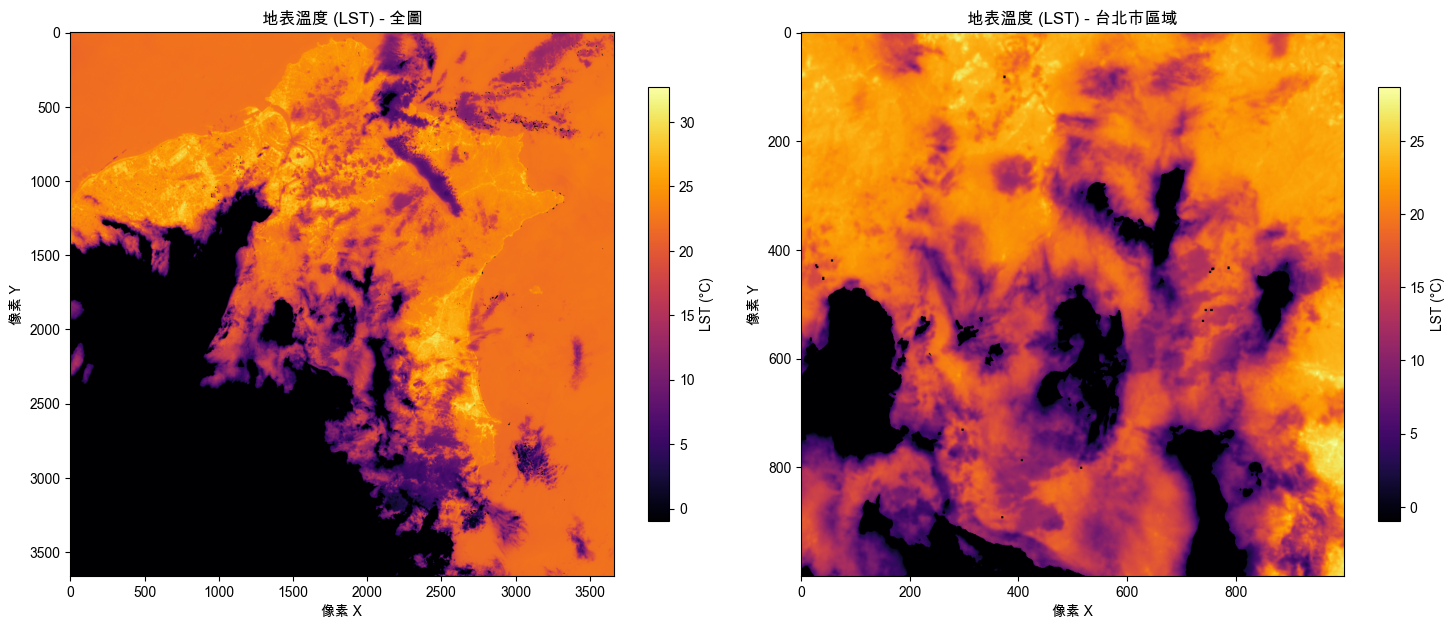


LST 統計資訊:
  範圍: 0.01°C 到 32.74°C
  平均: 20.01°C
  中位數: 22.07°C
  標準差: 5.31°C
  有效像素數: 9,481,229

=== 使用 GeoPandas 繪製 ===
   (台北市邊界文件存在，但需要座標轉換)


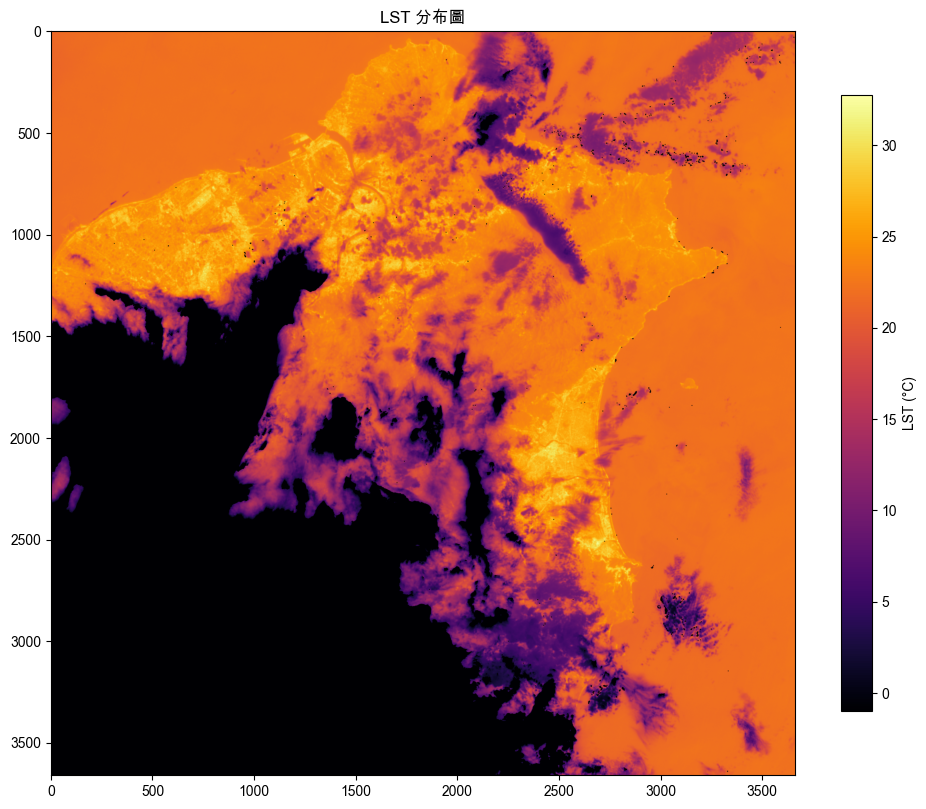

In [47]:
# 簡化版 LST 可視化（不需要 cartopy 的複雜依賴）
import matplotlib.pyplot as plt
import numpy as np

def plot_lst_simple(lst_data, transform=None, crs=None, title="LST 分布圖"):
    """
    簡化版 LST 可視化，不需要 cartopy
    """
    if 'lst' not in locals() and lst_data is None:
        print("⚠️ 沒有 LST 數據可繪製")
        return
    
    # 使用提供的數據或全域變數
    if lst_data is None:
        lst_data = lst
    
    # 過濾無效值
    valid_lst = lst_data[lst_data != -1]
    if len(valid_lst) == 0:
        print("⚠️ LST 數據中沒有有效值")
        return
    
    # 創建圖形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 左圖：全圖
    im1 = ax1.imshow(lst_data, cmap='inferno', origin='upper')
    ax1.set_title(f"{title} - 全圖")
    ax1.set_xlabel("像素 X")
    ax1.set_ylabel("像素 Y")
    
    # 添加顏色條
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('LST (°C)')
    
    # 右圖：聚焦台北市區域（如果數據足夠大）
    if lst_data.shape[0] > 1000 and lst_data.shape[1] > 1000:
        # 假設台北市在影像中央區域
        center_y, center_x = lst_data.shape[0] // 2, lst_data.shape[1] // 2
        crop_size = 500  # 裁剪大小
        
        y_start = max(0, center_y - crop_size)
        y_end = min(lst_data.shape[0], center_y + crop_size)
        x_start = max(0, center_x - crop_size)
        x_end = min(lst_data.shape[1], center_x + crop_size)
        
        taipei_crop = lst_data[y_start:y_end, x_start:x_end]
        
        im2 = ax2.imshow(taipei_crop, cmap='inferno', origin='upper')
        ax2.set_title(f"{title} - 台北市區域")
        ax2.set_xlabel("像素 X")
        ax2.set_ylabel("像素 Y")
        
        cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
        cbar2.set_label('LST (°C)')
    else:
        # 如果影像太小，只顯示全圖
        ax2.imshow(lst_data, cmap='inferno', origin='upper')
        ax2.set_title(f"{title} - 重複顯示")
        ax2.set_xlabel("像素 X")
        ax2.set_ylabel("像素 Y")
    
    plt.tight_layout()
    plt.show()
    
    # 顯示統計資訊
    print(f"\nLST 統計資訊:")
    print(f"  範圍: {np.min(valid_lst):.2f}°C 到 {np.max(valid_lst):.2f}°C")
    print(f"  平均: {np.mean(valid_lst):.2f}°C")
    print(f"  中位數: {np.median(valid_lst):.2f}°C")
    print(f"  標準差: {np.std(valid_lst):.2f}°C")
    print(f"  有效像素數: {len(valid_lst):,}")

def plot_lst_with_geopandas(lst_data, taipei_boundary_file=None):
    """
    使用 geopandas 進行地理可視化（較簡單的替代方案）
    """
    try:
        import geopandas as gpd
        import matplotlib.patches as patches
        
        if 'lst' not in locals() and lst_data is None:
            print("⚠️ 沒有 LST 數據可繪製")
            return
        
        if lst_data is None:
            lst_data = lst
        
        # 過濾無效值
        valid_lst = lst_data[lst_data != -1]
        if len(valid_lst) == 0:
            print("⚠️ LST 數據中沒有有效值")
            return
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        
        # 繪製 LST
        im = ax.imshow(lst_data, cmap='inferno', origin='upper')
        ax.set_title("LST 分布圖")
        
        # 如果有台北市邊界文件，嘗試載入並疊加
        if taipei_boundary_file and os.path.exists(taipei_boundary_file):
            try:
                gdf = gpd.read_file(taipei_boundary_file)
                # 這裡需要座標轉換，暫時跳過
                print("   (台北市邊界文件存在，但需要座標轉換)")
            except:
                print("   (無法載入台北市邊界文件)")
        
        # 添加顏色條
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label('LST (°C)')
        
        plt.show()
        
    except ImportError:
        print("⚠️ 需要安裝 geopandas: pip install geopandas")
        # 回退到簡單版本
        plot_lst_simple(lst_data)

# 檢查並繪製 LST
if 'lst' in locals():
    print("=== 繪製 LST 分布圖 ===")
    plot_lst_simple(lst, title="地表溫度 (LST)")
    
    # 嘗試使用 geopandas 版本
    taipei_boundary_file = "taipei_boundary.geojson"
    if os.path.exists(taipei_boundary_file):
        print("\n=== 使用 GeoPandas 繪製 ===")
        plot_lst_with_geopandas(lst, taipei_boundary_file)
else:
    print("⚠️ 尚未計算 LST，無法繪圖")
    print("請先執行 LST 計算的 cell")
